In [249]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [250]:
%autoreload

import warnings
import os.path
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import geopy
import xgboost as xgb
import os
import shutil
import geopandas as gpd
import catboost as cb

from xgboost import XGBRegressor, plot_importance, to_graphviz, plot_tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from k_fold import random_k_fold
from shapely import wkt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from utils import squared_log, rmsle_xgb, add_city_centre_dist, group_ages, to_categorical, nan_to_string, object_encoder
from k_fold import random_k_fold, _rmsle
from scipy.stats import uniform, randint

pd.options.mode.chained_assignment = None  # default='warn'

spatial = pd.read_csv('data/grunnkrets_norway_stripped.csv')
age = pd.read_csv('data/grunnkrets_age_distribution.csv')
income = pd.read_csv('data/grunnkrets_income_households.csv').set_index(['grunnkrets_id', 'year']).add_prefix('income_').reset_index()
households = pd.read_csv('data/grunnkrets_households_num_persons.csv')
submission = pd.read_csv('data/sample_submission.csv')
plaace = pd.read_csv('data/plaace_hierarchy.csv')
busstops = pd.read_csv('data/busstops_norway.csv')

train = pd.read_csv('data/stores_train.csv')
test = pd.read_csv('data/stores_test.csv')

submission = pd.read_csv('data/sample_submission.csv')
model_name = "modeling/0002.model"


In [251]:
income.head()

,grunnkrets_id,year,income_all_households,income_singles,income_couple_without_children,income_couple_with_children,income_other_households,income_single_parent_with_children
0,14200105,2016,551700,270300,0,0,0,0
1,2311202,2015,577700,311800,0,682300,0,0
2,2310501,2015,668800,292500,0,842000,0,0
3,14200401,2016,507000,250700,0,0,0,0
4,14200105,2015,539900,275800,0,710300,0,0


In [252]:
households.head()

,grunnkrets_id,year,couple_children_0_to_5_years,couple_children_18_or_above,couple_children_6_to_17_years,couple_without_children,single_parent_children_0_to_5_years,single_parent_children_18_or_above,single_parent_children_6_to_17_years,singles
0,12010509,2015,0,0,4,0,0,0,0,4
1,14390206,2015,0,7,0,0,0,0,0,3
2,18040514,2015,10,0,0,0,0,0,0,7
3,18040804,2015,0,0,0,0,0,0,0,0
4,18200101,2015,0,6,0,0,0,0,0,4


In [253]:
def generate_features(df: pd.DataFrame, predictor: str = ''):
    age_ranges = [
        (0, 19),
        (20, 39),
        (40, 59),
        (60, 79),
        (80, 90),
    ]
    
    # Define datasets to be merged
    spatial_merge = spatial.drop(columns=['year']).drop_duplicates(subset=['grunnkrets_id'])
    age_groups_merge = group_ages(age, age_ranges)
    income_merge = income.drop(columns=['year']).drop_duplicates(subset='grunnkrets_id')
    households_merge = households.drop(columns=['year']).drop_duplicates(subset='grunnkrets_id')
    plaace_merge = plaace.drop_duplicates(subset='plaace_hierarchy_id')
    bus_data_train_merge = gpd.read_parquet('derived_data/stores_bus_stops_lt_1km_train').drop(columns=['geometry'])

    # Merge datasets
    df = df.merge(spatial_merge, on='grunnkrets_id', how='left')
    df = df.merge(age_groups_merge, on='grunnkrets_id', how='left')
    df = df.merge(income_merge, on='grunnkrets_id', how='left')
    df = df.merge(households_merge, on='grunnkrets_id', how='left')
    df = df.merge(plaace_merge, how='left')
    df = df.merge(bus_data_train_merge, on='store_id', how='left')
    df = add_city_centre_dist(df).drop(columns=['lon_center', 'lat_center'])

    # Handle categories for different predictors
    if predictor == 'xgb':
        df = object_encoder(df)
    elif predictor == 'catboost':
        print('hei')
        df = nan_to_string(df)
        print(df.isna().sum())
    else: 
        raise ValueError('Invalid predictor')

    features = [
        # 'store_name', 
        'mall_name', 
        'chain_name',
        # 'address', 
        'lat', 'lon',
        
        *age_groups_merge.drop(columns=['grunnkrets_id']).columns,
        *income_merge.drop(columns=['grunnkrets_id']).columns,
        *households_merge.drop(columns=['grunnkrets_id']).columns,
        'lv1_desc', 'lv2_desc',
        *bus_data_train_merge.drop(columns=['store_id']).columns,
        'dist_to_center'
    ]

    print(features)
        
    return df[features]


label_name = 'revenue'
X = train.drop(columns=[label_name])
y = train[label_name]


In [254]:
def plot_corr(data):
  df = data[['revenue', 
    # 'age_0_19', 'age_20_39', 'age_40_59', 'age_60_79', 'age_80_90', 
    # 'bus_stops_count', 'Mangler viktighetsnivå', 'Standard holdeplass', 'Lokalt knutepunkt', 'Nasjonalt knutepunkt', 'Regionalt knutepunkt', 'Annen viktig holdeplass', 
    'dist_to_center', 'lat','lon'
    ]]
  df['knutepunkt'] = data[['Lokalt knutepunkt', 'Nasjonalt knutepunkt', 'Regionalt knutepunkt']].sum(axis=1)
  # df.revenue = np.exp(df.revenue)
  # df.bus_stops_count = np.sqrt(df.bus_stops_count)
  df = df[df.dist_to_center < 70_000]
  # df.dist_to_center = np.log(df.dist_to_center)
  
  plt.figure(figsize=(15, 15))
  pairplot = sns.pairplot(df)
  # heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)


# data_full =  pd.merge(X_train, y_train, left_index=True, right_index=True) 
# plot_corr(data_full)


In [255]:
def clear_buffers(X_train, y_train, X_val, y_val):
    # Clear buffers
    folder = os.path.join(os.getcwd(), 'modeling')

    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        if os.path.isfile(file_path):
            os.unlink(file_path)
            print(f'Deleted file: {file_path}')

    train_buffer_path = 'modeling/train.buffer'
    test_buffer_path = 'modeling/test.buffer'

    dtrain = xgb.DMatrix(data=X_train, label=np.log1p(y_train), enable_categorical=True)
    dtrain.save_binary(train_buffer_path)
    print(f'--> {train_buffer_path} created and saved.')

    dvalid = xgb.DMatrix(data=X_val, label=y_val, enable_categorical=True)
    dvalid.save_binary(test_buffer_path)
    print(f'--> {test_buffer_path} created and saved.')

    return dtrain, dvalid

In [256]:
def train_xgb_model(X_train, y_train, X_val, y_val):
    # params = {'colsample_bytree': 0.7717138210314867, 'learning_rate': 0.047506668950627134, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 223, 'subsample': 0.9929036803032936}
    
    rand_search_model = random_k_fold(X_train, y_train, verbose=1, n_iter=100)
    params = rand_search_model.best_params_
    print(rand_search_model.best_score_, params)
    params['disable_default_eval_metric'] = True

    # y_pred_train = rand_search_model.predict(X_train)
    # y_pred_val = rand_search_model.predict(X_val)
    # print(_rmsle(y_train, y_pred_train))
    # print(_rmsle(y_val, y_pred_val))
    model = rand_search_model
    
    # params = {'colsample_bytree': 0.8601277878899238, 'eval_metric': _rmsle, 'gamma': 0.12760202929262826, 'learning_rate': 0.07356461924449906, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 306, 'objective': 'reg:squaredlogerror', 'subsample': 0.8993341396761092}
    # model = XGBRegressor()
    # model.set_params(**params)
    # model.fit(X_train, y_train)
    # y_pred_train = model.predict(X_train)
    # y_pred_val = model.predict(X_val)
    # print(_rmsle(y_train, y_pred_train))
    # print(_rmsle(y_val, y_pred_val))
    

    # print('Clearing and creating buffers...')
    # dtrain, dvalid = clear_buffers(X_train, y_train, X_val, y_val)
    # print(dtrain, dvalid)

    # X_test = generate_features(test, predictor='xgb')
    # dtest = xgb.DMatrix(data=X_test, enable_categorical=True)

    # print("\nAttempting to start prediction...")
    # y_pred_val = model.predict(dtest, ntree_limit=model.best_iteration)
    # print("--> Prediction finished.")

    # print("\nAttempting to save prediction...")
    # submission['predicted'] = np.array(y_pred_val)
    # submission.to_csv('submissions/kfold_submission.csv', index=False)
    # print("--> prediction saved with features as name in submission folder.")

    # num_round = 999
    # watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

    # print("Attempting to start training...")
    # model = xgb.train(
    #     params=params, 
    #     dtrain=dtrain, 
    #     num_boost_round=num_round, 
    #     obj=squared_log,
    #     custom_metric=rmsle_xgb,
    #     evals=watchlist, 
    #     early_stopping_rounds=10, 
    #     verbose_eval=20)
    # print("--> model trained.")
    # print('Best score:', model.best_score)

    # print("Attempting to save model...")
    # model.save_model(model_name)
    # print("--> model saved.")

    return model


X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=.8)
X_train, X_val = generate_features(X_train, predictor='xgb'), generate_features(X_val, predictor='xgb')

model = train_xgb_model(X_train, y_train, X_val, y_val)

['mall_name', 'chain_name', 'lat', 'lon', 'age_0_19', 'age_20_39', 'age_40_59', 'age_60_79', 'age_80_90', 'income_all_households', 'income_singles', 'income_couple_without_children', 'income_couple_with_children', 'income_other_households', 'income_single_parent_with_children', 'couple_children_0_to_5_years', 'couple_children_18_or_above', 'couple_children_6_to_17_years', 'couple_without_children', 'single_parent_children_0_to_5_years', 'single_parent_children_18_or_above', 'single_parent_children_6_to_17_years', 'singles', 'lv1_desc', 'lv2_desc', 'store_id', 'bus_stops_count', 'Mangler viktighetsnivå', 'Standard holdeplass', 'Lokalt knutepunkt', 'Nasjonalt knutepunkt', 'Regionalt knutepunkt', 'Annen viktig holdeplass', 'dist_to_center']
['mall_name', 'chain_name', 'lat', 'lon', 'age_0_19', 'age_20_39', 'age_40_59', 'age_60_79', 'age_80_90', 'income_all_households', 'income_singles', 'income_couple_without_children', 'income_couple_with_children', 'income_other_households', 'income_sin

KeyboardInterrupt: 

In [ ]:
print(model.best_score_)
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
print(_rmsle(y_train, y_pred_train))
print(_rmsle(y_val, y_pred_val))

-0.7591518032423027
('RMSLE', 0.5834310114243849)
('RMSLE', 0.9600328287300616)


In [ ]:
def xgb_prediction(X_test, model):
    dtest = xgb.DMatrix(data=X_test, enable_categorical=True)

    print("\nAttempting to start prediction...")
    y_pred = model.predict(dtest, ntree_limit=model.best_iteration)
    print("--> Prediction finished.")

    print("\nAttempting to save prediction...")
    submission['predicted'] = np.array(y_pred)
    submission.to_csv('submissions/submission.csv', index=False)
    print("--> prediction saved with features as name in submission folder.")


# X_test = generate_features(test, predictor='xgb')
# xgb_prediction(X_test, model)

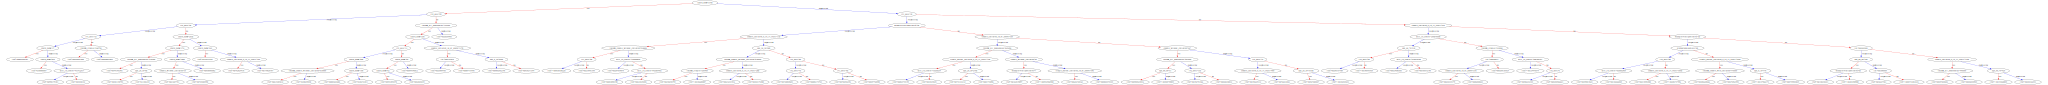

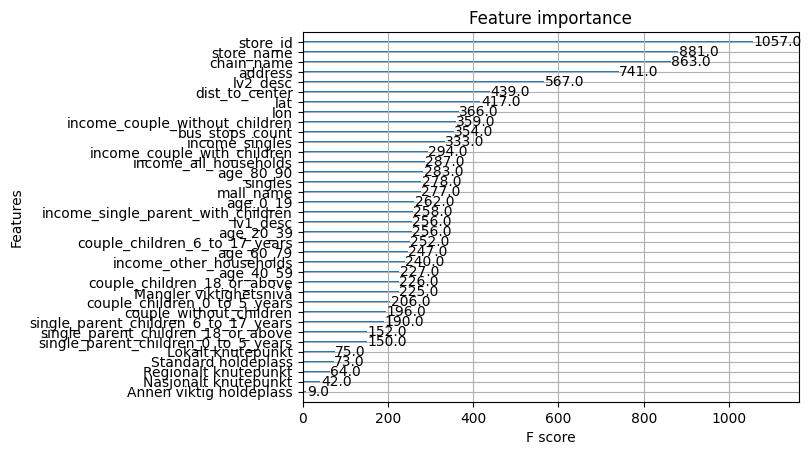

In [ ]:
xgb_model = model.best_estimator_
plot_importance(xgb_model)
xgb.to_graphviz(xgb_model, num_trees=1)

### Prepare features for Catboost predictor

In [ ]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=.8)
# X_train, X_val = generate_features(X_train, predictor='catboost'), generate_features(X_val, predictor='catboost')
# X_test = generate_features(test, predictor='catboost')

# cat_features = list(X_train.select_dtypes(include=[object]).columns)

# train_pool = cb.Pool(X_train, y_train, cat_features=cat_features)
# test_pool = cb.Pool(X_test, cat_features=cat_features)

# # X_train[X_train.columns[X_train.isna().any()].tolist()]


In [ ]:
# params = {
#     'depth': randint(2, 20),
#     'learning_rate': uniform(0.01, 0.4),
#     'iterations': randint(10, 1000)
# }

# model = cb.CatBoostRegressor(loss_function='RMSE')

# model.randomized_search(train_pool, param_distributions=params, cv=5)

# pred = model.predict(X_val)
# rmse = (np.sqrt(mean_squared_log_error(y_val, pred)))
# print('Testing performance')
# print('RMSE: {:.2f}'.format(rmse))